<h1 style="font-family:verdana;"> <center>🛠 Product Tagging for E-Commerce : Work in Progress 🛠</center> </h1>


***

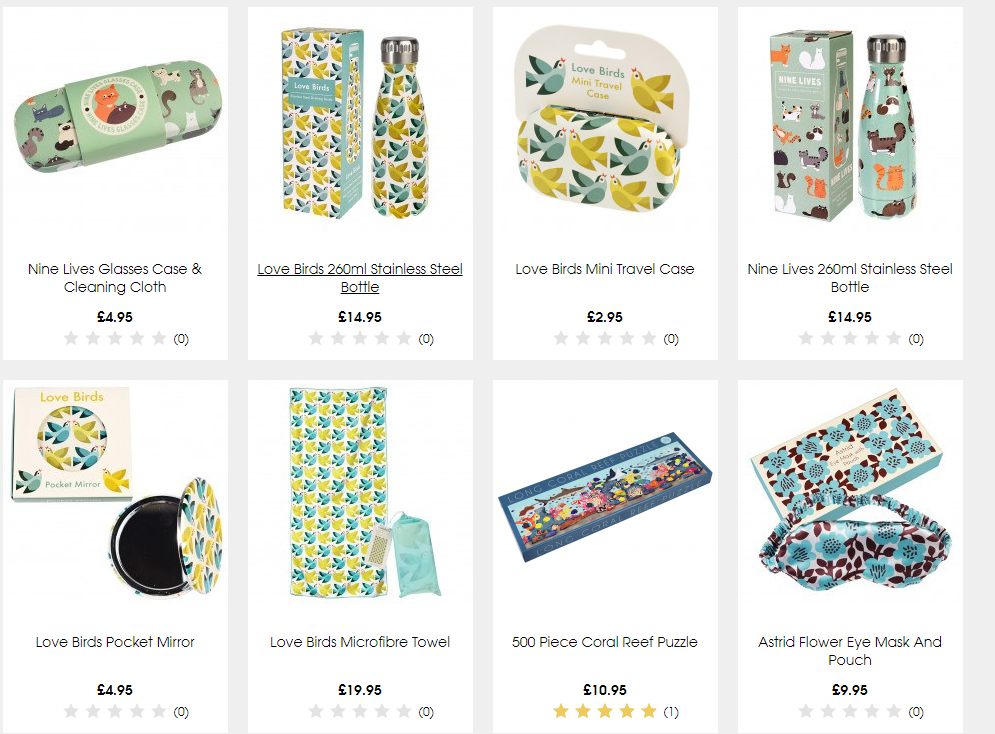

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> 2 years after working on the "Online Retail Dataset" I wanted to come back to this project and see if I could push it further and make the best out of this data. <span style="color:green;"> Luckily </span> for me, a V2 of the dataset emerged and we now have the 2009 data. More data equals more fun so let's give it a try. 
    
<div style="font-size:15px; font-family:verdana;"> This new project will be in divided in 3 parts: <br><br>
    
<ol>
    <li><span style="color:green;">Product Tagging </span> (Current step) </li>
    <li>Feature Engineering and Customer segmentation</li>
    <li>Dashboard devolpment with Dash from Plotly</li>
</ol>

</div>

<br>
    
    
<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
        📌 &nbsp; I would like to take this opportunity to ask you if you know any datasets in gaming industry where I could do some customer segmentation.
</div>
<br><br>


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#202EF9;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            The method I'll be using here is very simple since we don't have a lot of information in the description column:
            <ol>
                <li>Cleaning the dataset</li>
                <li>Creating tags</li>
                <li>Semi manually Tagging most popular products</li>
                <li>Training classifiers on tagged products</li>
                <li>Predicting tags for products without tags</li>
            </ol>
        </p>
</div>

***

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

<h1 id="clean" style="font-family:verdana;"> 
    <center>1. Basic cleaning 🧹
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#clean">¶</a>
    </center>
</h1>

> <h1 id="missing" style="font-family:verdana;"> 
>          1.1 Missing data 👻
>         <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#missing">¶</a>
> 
</h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> After an exploratory analysis of the dataset, it appears that <span style="color:crimson;"> 22% </span>of the customer ids are missing which is very problematic since I want to do a <span style="color:crimson;"> Customer </span> Segmentation later. I've tried looking at the invoice number or date without success. It's a shame that we have to lose 22% of the data but we don't have a choice. (Even though I could only use it for the product tagging but I don't think that it'll change anything)
</p>

In [ ]:
df = df.dropna(subset=["Customer ID"])

<h1 id="duplicates" style="font-family:verdana;"> 
         1.2 Duplicate values
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#duplicates">¶</a>

</h1>

In [ ]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Since duplicates values aren't following one another in the dataset, I could think that the customer added the same product in his basket several times without updating the quantity. The choice is here also hard to make. But, by trying this experiment on a few websites, it seems that the quantity is always updated when you add the same product. So I'll consider them as duplicates even though this data is from 2010. 
</p>

<h1 id="dupplicates" style="font-family:verdana;"> 
         1.3 Stock Code
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#dupplicates">¶</a>

</h1>

In [ ]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

In [ ]:
for code in list_special_codes : 
    df = df[df['StockCode']!= code]

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> In this dataset, there are several specific transactions which aren't products. For example, we can have a line with 'Discount' as a description. This probably means that the customer had a discount during his purchase. This will be important when I'll make new features describing customers but for now I don't need it. 
</p>

***

<h1 id="products_tag" style="font-family:verdana;"> 
    <center>2. Product Tagging 🏪
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#products_tag">¶</a>
    </center>
</h1>

<h1 id="desc_clean" style="font-family:verdana;"> 
         2.1 Cleaning the description
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#desc_clean">¶</a>

</h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> I'll take this opportunity to try a new nlp library I recently discovered : TextHero in order to clean my data. It is pretty convenient since with one line of code I can do several processing functions like lower_case, removing strop words, lemmatization, ...
    
</p>

In [ ]:
!pip install texthero


In [ ]:
import texthero as hero
import plotly.express as px

In [ ]:
product_df = pd.DataFrame()
product_df['Description'] = df['Description'].pipe(hero.clean)

In [ ]:
tw = hero.visualization.top_words(product_df['Description']).head(40)

fig = px.bar(tw)
fig.show()

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> From this graph, I decided to make 3 different features out of the product description : color, category and design. I'll group several thing in design since it would like product caracteristics. For example, "Retrospot", "Vintage", "Feltcraft", ...
    And in categories we'll have something like "Cake", "Christmas", "Bottle", ...
    I also took a look at bi-grams even though I didn't put it in this notebook. 
</p>

<h1 id="prod_color" style="font-family:verdana;"> 
         2.2 Product's color 🌈
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_color">¶</a>

</h1>

In [ ]:
from nltk.tokenize import ToktokTokenizer
token = ToktokTokenizer()

In [ ]:
def TagExtractor(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if  w in tags]
    
    return ' '.join(map(str, filtered))

In [ ]:
def TagRemove(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in tags]
    
    return ' '.join(map(str, filtered))

In [ ]:
colors = ['black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'white', 'yellow', 'ivory']

In [ ]:
product_df['ProductColor'] = product_df['Description'].apply(lambda x: TagExtractor(x, colors)) 

In [ ]:
 product_df['Description'] = product_df['Description'].apply(lambda x: TagRemove(x, colors)) 

In [ ]:
tw = hero.visualization.top_words(product_df['ProductColor']).head(20)

fig = px.bar(tw)
fig.show()

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> To extract colors I basically made a list of colors and wrote a function which will iterate in the dataframe, and each product description will be divided in words. And, if we find one of the colors in the product description we put it in a list. This feature could be very interesting because we could know if a customer has a favourite color which could lead to personalized marketing campaigns for the company. 
</p>

<h1 id="prod_des" style="font-family:verdana;"> 
         2.3 Product's design
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_des">¶</a>

</h1>

In [ ]:
Design = ['gingham', 'butterfly', 'chocolate', 'zinc', 'hearts', 'star', 'skull', 'dolly', 'wood', 'retro', 'strawberry',
         'mini', 'polkadot', 'spot', 'cream', 'rose', 'spaceboy', 'ceramic', 'glasse', 'vintage', 'retrospot', 'heart',
         'spots', 'skulls', 'scandinavian', 'london', 'french', 'wooden', 'woodland', 'bakelike', 'feltrcraft', 'porcelain',
         'spaceboy', 'glass', 'traditional', 'bird', 'birds', 'flower', 'antique', 'tube']

In [ ]:
product_df['Design'] = product_df['Description'].apply(lambda x: TagExtractor(x, Design)) 

In [ ]:
stop_words = ['set', 'pack', 'small', 'large']

In [ ]:
 product_df['Description'] = product_df['Description'].apply(lambda x: TagRemove(x, (Design+stop_words))) 

In [ ]:
tw = hero.visualization.top_words(product_df['Design']).head(20)

fig = px.bar(tw)
fig.show()

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> I used the same process for the design and category. We can see that there are several kind of collections in there. I don't know if this feature will be useful but it wouldn't hurt keeping it for later, especially for the future dashboard. 
</p>

<h1 id="prod_cat" style="font-family:verdana;"> 
         2.4 Product's category
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat">¶</a>

</h1>

<h2 id="prod_cat_man" style="font-family:verdana;"> 
         2.4.1 Semi manually tagging products
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat_man">¶</a>

</h2>

In [ ]:
Categories = ['bag', 'box', 'cake', 'christmas', 'hanging', 'light', 'holder', 'sign', 'jumbo', 'lunch', 'paper', 'tea', 'card',
              'cases', 'decoration', 'water', 'bottle', 'mug', 'party', 'garden', 'wrap', 'bowl', 'birthday', 
              'photo', 'frame', 'candle', 'key', 'ring', 'travel', 'egg', 'cup', 
              'lights', 'cutlery', 'candles', 'door', 'gift', 'clock', 'trinket', 
              'drawer', 'stand', 'pencils', 'ribbons', 'napkins', 'notebook', 'photo', 'alarm', 'dog',
             'kitchen', 'storage', 'childrens', 'cup', 'cat', 'wall', 'art', 'cushion', 'cover', 'popcorn', 'soap', 'baking', 'door']


In [ ]:
product_df['Categories'] = product_df['Description'].apply(lambda x: TagExtractor(x, Categories)) 

In [ ]:
pd.DataFrame(product_df['Categories'].value_counts()).to_excel('product_categories.xlsx')

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> From here, I took it on excel. I renamed and grouped categories into labels in order to have something more reliable for the classifiers later on. 
    
</p>

In [ ]:
product_tags = pd.read_excel('/kaggle/input/product-categories/product_categories V2.xlsx')

In [ ]:
product_tags.head()

In [ ]:
product_df = product_df.merge(product_tags, on='Categories', how='left')

In [ ]:
product_df.loc[(product_df.Description =='wicker'), 'Labels'] = 'Wicker'

product_df.loc[(product_df.Description =='assorted colour ornament'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='tissues'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='chalkboard'), 'Labels'] = 'Stationary'

product_df.loc[(product_df.Description =='milk jug'), 'Labels'] = 'Tableware'

product_df.loc[(product_df.Description =='measuring spoons'), 'Labels'] = 'Baking'

product_df.loc[(product_df.Description =='snap cards'), 'Labels'] = 'Cards'

In [ ]:
product_df.loc[(product_df.Description =='regency cakestand tier'), 'Labels'] = 'Cake Decoration'

product_df.loc[(product_df.Description =='heart wicker small'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='heart wicker large'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='edwardian parasol'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='regency teacup saucer'), 'Labels'] = 'Tea'

product_df.loc[(product_df.Description =='natural slate heart chalkboard'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='french metal door sign'), 'Labels'] = 'Door Sign'

product_df.loc[(product_df.Description =='love building block word'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='vintage snap cards'), 'Labels'] = 'Cards'

product_df.loc[(product_df.Description =='scottie dog hot water bottle'), 'Labels'] = 'Water Bottle'

product_df.loc[(product_df.Labels =='Holders'), 'Labels'] = 'Holding Decoration'

In [ ]:
product_df['Labels'].value_counts().sum() /product_df['Labels'].shape[0]*100

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> One last finishing touch and we're done. With this semi-manual work almost 60% of the data is tagged which should give us enough data for the next step
</p>

<h2 id="prod_cat_auto" style="font-family:verdana;"> 
         2.4.2 Training classification algorithms 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat_auto">¶</a>

</h2>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> I've now landed on the fun and last part of this notebook. I'll use my labeled data in order to train classifiers and validate results on it. Once this is done, I'll simply choose the best classifiers and predict labels for the test data. This was the plan but it didn't go that smoothly. 
</p>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from xgboost import XGBClassifier



In [ ]:
X = product_df.dropna(subset=['Labels']).drop_duplicates(subset=['Description'])['Description']
X_test = product_df[product_df['Labels'].isnull()].drop_duplicates(subset=['Description'])['Description']

In [ ]:
X.shape, X_test.shape

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
y = le.fit_transform(product_df.dropna(subset=['Labels']).drop_duplicates(subset=['Description'])['Labels'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 46) # Do 60/40 split

In [ ]:
X_vectorizer = TfidfVectorizer(analyzer = 'word',
                            )

In [ ]:
X_train = X_vectorizer.fit_transform(X_train)
X_val =  X_vectorizer.transform(X_val)
X_test_tfidf = X_vectorizer.transform(X_test)

In [ ]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy score: {}".format(accuracy_score(y_val, y_pred)))
    print("---")    

In [ ]:
dummy = DummyClassifier(strategy='prior')
sgd = SGDClassifier()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()


for classifier in [dummy, sgd, mn, svc, perceptron, pac, mlpc, rfc, xgb]:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    print_score(y_pred, classifier)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> We could have better results by tuning some parameterers but for now I'm going to keep it that way and come back to it later. 
</p>

In [ ]:
y_pred_test = rfc.predict(X_test_tfidf) 

In [ ]:
prods_non_labeled = pd.DataFrame()

In [ ]:
prods_non_labeled['Description']= X_test

In [ ]:
prods_non_labeled['Labels'] = le.inverse_transform(y_pred_test)

In [ ]:
prods_non_labeled

<center style="font-family:cursive; font-size:18px; color:#159364;"> I will keep updating this notebook right and feel free to make suggestions. Thank you for taking your time to read my notebook 🙏 </center>

***